In [167]:
%pip install --quiet -U langgraph langchain_groq langgraph_sdk langgraph-prebuilt langchain-community wikipedia trustcall

In [168]:
from typing import TypedDict,List
class UserProfile(TypedDict):
  user_name:str
  interest:List[str]

In [169]:
user_profile:UserProfile={
    "user_name":"khuram",
    "interest":["football","cricket"]
}
user_profile

{'user_name': 'khuram', 'interest': ['football', 'cricket']}

In [170]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

user_id="1"
namespace_for_memory=(user_id,"memory")
key="user_profile"
value=user_profile
in_memory_store.put(namespace_for_memory,key,value)

In [171]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict)

<bound method SearchItem.dict of Item(namespace=['1', 'memory'], key='user_profile', value={'user_name': 'khuram', 'interest': ['football', 'cricket']}, created_at='2025-08-20T20:43:25.556795+00:00', updated_at='2025-08-20T20:43:25.556798+00:00', score=None)>


In [172]:
profile=in_memory_store.get(namespace_for_memory,"user_profile")
profile.value

{'user_name': 'khuram', 'interest': ['football', 'cricket']}

In [173]:
import os
import sqlite3
from google.colab import userdata

api_key = userdata.get("groq_api_key")
os.environ["GROQ_API_KEY"] = api_key
os.environ["LANGCHAIN_TRACKING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langchain-academy"

In [174]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=1.0,
    model_name="llama3-8b-8192",
    verbose=True
)

In [175]:
llm_with_structure=llm.with_structured_output(UserProfile)

In [176]:
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
structure_output=llm_with_structure.invoke([HumanMessage("My name is khuram i like chess")])
structure_output

{'interest': ['chess'], 'user_name': 'khuram'}

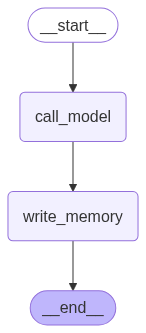

In [177]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig
from groq import BadRequestError

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """
Based on the following chat history, create or update a user profile memory.
The user profile should contain the user's name and a list of their interests.
Return ONLY valid JSON in the following format:

{
  "user_name": "<string>",
  "interest": ["<string>", "<string>", ...]
}

Here is the existing memory (it may be empty): {memory}
"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    formatted_memory = None
    if existing_memory and isinstance(existing_memory.value, dict):
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interest', []))}"
        )


    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    formatted_memory = None
    if existing_memory and isinstance(existing_memory.value, dict):
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interest', []))}"
        )

    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    try:
        # Invoke the model to produce structured output that matches the schema
        new_memory = llm_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

        # Overwrite the existing use profile memory
        key = "user_memory"
        store.put(namespace, key, new_memory)
        print("User memory updated successfully.")

    except BadRequestError as e:
        print(f"Failed to write user memory: {e}")


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [179]:
config={"configurable":{"thread_id":"1","user_id":"1"}}
input_messages=[HumanMessage(content="hi my name is khuram and i like to bike around the islamabad")]
for chunk in graph.stream({"messages":input_messages},config,stream_node="values"):
  if "call_model" in chunk:
    chunk["call_model"]["messages"].pretty_print()

================================== Ai Message ==================================

Khuram! I remember you're from Islamabad and enjoy biking. How was your latest bike ride around the city? Did you explore any new trails or routes? I'm here to share some recommendations or help you plan your next adventure if you'd like!


KeyError: '\n  "user_name"'

In [ ]:
# After running your graph...
namespace = ("memory", config["configurable"]["user_id"])
saved_memory = across_thread_memory.get(namespace, "user_memory")

print("===== SAVED MEMORY =====")
print(saved_memory)


In [ ]:
conversation = [HumanMessage(content="Hi, I'm khuram."),
                AIMessage(content="Nice to meet you, khuram."),
                HumanMessage(content="I really like biking around Islamabad.")]

In [ ]:
from trustcall import create_extractor
from pydantic import BaseModel, Field
from typing import List
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interest: List[str] = Field(description="A list of the user's interests") # Changed interests to interest

trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = """Extract the user profile from the following conversation.
Return ONLY valid JSON in the following format:
{
  "user_name": "<string>",
  "interest": ["<string>", "<string>", ...]
}
"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

In [ ]:
for m in result["messages"]:
    m.pretty_print()

In [ ]:
schema = result["responses"]
schema

In [ ]:
schema[0].model_dump()

In [ ]:
result["response_metadata"]

In [ ]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."),
                        AIMessage(content="Nice to meet you, khuram."),
                        HumanMessage(content="I really like biking around Islamabad."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the provided user profile JSON document with new information from the following conversation.
Return ONLY the updated user profile JSON in the following format:
{{
  "user_name": "<string>",
  "interest": ["<string>", "<string>", ...]
}}
"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [ ]:
for m in result["messages"]:
    m.pretty_print()

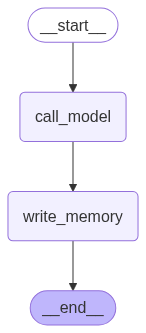

In [180]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore


# Schema
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [181]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is khuram")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is khuram
================================== Ai Message ==================================

Nice to meet you, Khuram! I don't have any memory of you yet, but I'm happy to start fresh and assist you with any questions or topics you'd like to discuss. Is there something specific you'd like to talk about or ask me?


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}

In [182]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a great city for biking! I'll make note of that so I can provide more personalized recommendations for you in the future.

If you're looking for some great bike routes in San Francisco, I'd be happy to suggest a few. There are plenty of scenic routes that take you through Golden Gate Park, along the waterfront, and across the Golden Gate Bridge. Which part of the city would you like to explore?

Also, I can recommend some of the best bike-friendly areas in the city, such as the Wiggle, a popular route that takes you through the Haight-Ashbury neighborhood, and the Golden Gate Park bike path, which offers stunning views of the city and the park.

What kind of bike ride are you looking for - leisurely, adventurous, or something else?


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ' \n\n/tool-use>{"tool_call":{"id":"pending","type":"function","function":{"name":"UserProfile"},"parameters":{"user_name":"khuram","user_location":"San Francisco","interests":["biking","outdoors"]}}}'}}

In [183]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

AttributeError: 'NoneType' object has no attribute 'dict'